In [6]:
import xarray
import pandas

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [7]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb

In [8]:
nino3Domain=_index.sstIndex['nino3']

nino3Domain

{'latMin': -5, 'latMax': 5, 'longMin': 210, 'longMax': 270}

In [9]:
#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino3Box={
    'xy':[nino3Domain['longMin']-mapCentre, nino3Domain['latMin']],
    'width':nino3Domain['longMax']-nino3Domain['longMin'],
    'height':nino3Domain['latMax']-nino3Domain['latMin']
}

nino3Box

{'xy': [0, -5], 'width': 60, 'height': 10}

In [10]:
nino4Domain=_index.sstIndex['nino4']

#figure out where to plot nino34 box on anomaly plots
mapCentre=210
nino4Box={
    'xy':[nino4Domain['longMin']-mapCentre, nino4Domain['latMin']],
    'width':nino4Domain['longMax']-nino4Domain['longMin'],
    'height':nino4Domain['latMax']-nino4Domain['latMin']
}

nino4Box

{'xy': [-50, -5], 'width': 50, 'height': 10}

# Load the sst dataset

In [11]:
paths = !find /scratch/w35/as2285/ersst/*.nc

In [12]:
xrLs=list()
for iPath in paths:
    xrLs.append(
        to_365day_monthly(
            xarray.open_dataset(iPath, use_cftime=True).isel(lev=0,drop=True)
        )
    )
sstXr=xarray.concat(xrLs,'time')

In [13]:
sstClimat=sst.calculateClimatology(sstXr.sst)

In [14]:
sstIndex=sst.calculateIndex(sstXr.sst, sstClimat)

In [15]:
indexXr=tp.averageForTimePeriod(sstIndex)

In [16]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables:
    nino34NoDetrend         (year) float64 1.183 0.1822 ... 0.4823 -0.8275
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502
    westIONoDetrend         (year) float64 -0.4674 -0.3855 ... 0.8908 0.4204
    eastIO                  (year) float64 -0.1259 0.4451 ... -1.003 0.1331
    backgroundSstNoDetrend  (year) float64 -0.01563 -0.1544 ... 0.5034 0.1919
    westIO                  (year) float64 -0.3837 -0.211 ... 0.438 0.1493
    eastIONoDetrend         (year) float64 -0.2096 0.2706 ... -0.5503 0.4041
    nino34                  (year) float64 1.198 0.3367 ... -0.02116 -1.019
    nino3                   (year) float64 1.068 0.02561 ... -0.3024 -0.8708
    nino4                   (year) float64 0.4491 0.2838 ... 0.4623 -0.6939
    dmi                     (year) float64 -0.2578 -0.656 ... 1.441 0.01628

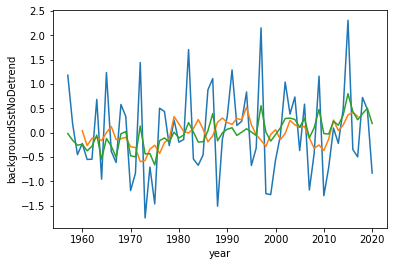

In [17]:
indexXr.nino34NoDetrend.plot()
indexXr.nino34NoDetrend.rolling(year=7,center=True).mean('year').plot()
indexXr.backgroundSstNoDetrend.plot()

In [18]:
varsToDetrend=[
    'dmi',
    'eastIO',
    'nino34',
    'westIO',
    'nino4',
    #'samWinter',
    #'samSummer'
]

In [19]:
#detrend
indexXr['dmiNoDetrend']=indexXr.dmi
            
for iVar in varsToDetrend:
    indexXr[iVar]=(
        indexXr[iVar+'NoDetrend']
        -indexXr[iVar+'NoDetrend'].rolling(
            year=11,min_periods=5,center=True
        ).mean('year')
    )




In [20]:
# and EC index too
sstAnoms=ec.sstAnoms(sstXr.sst, sstXr.sst)

#create the solver
solver=ec.eofSolver(sstAnoms)

#caluculate pcs and eofs
pcXr, pFit, eofsXr = ec.pcs(solver)

In [21]:
pcXr=pcXr/pcXr.std()

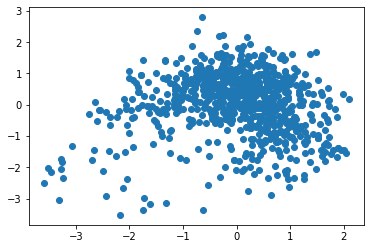

In [22]:
plt.scatter(pcXr.pc1, pcXr.pc2)

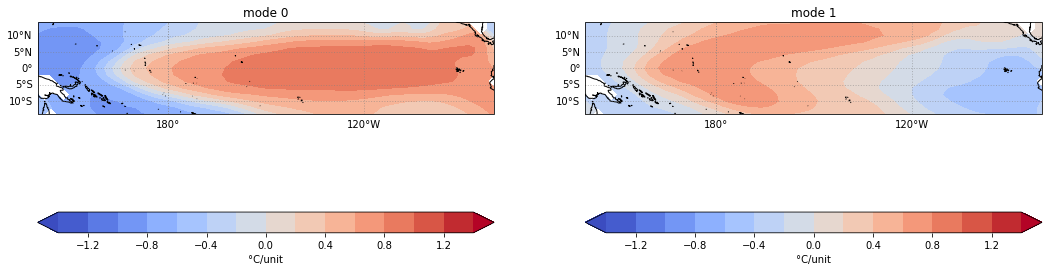

In [23]:
multiplyBy=[-1,1]

#Calc e and c
ecXr=xarray.Dataset()
ecXr['eIndex']=(multiplyBy[0]*pcXr.pc1-multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)
ecXr['cIndex']=(multiplyBy[0]*pcXr.pc1+multiplyBy[1]*pcXr.pc2)/numpy.sqrt(2)

#Average over warmseason and store
allWarmSeasXr=tp.averageForTimePeriod(ecXr)

#first plots of pc1 and pc2
fig=plt.figure(figsize=(18,12))
for mode in [0,1]:
    ax=fig.add_subplot(1,2,mode+1,
                   projection=ccrs.Miller(central_longitude=mapCentre))
    ec.ensoPlotter(
        multiplyBy[mode]*eofsXr.sel(mode=mode), ax)
    plt.title("mode " + str(mode))
plt.show()

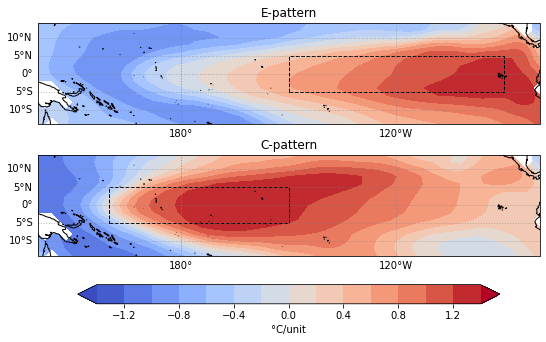

In [24]:
#then plots of e pattern and c pattern
fig=plt.figure(figsize=(9,6))
ax=fig.add_subplot(2,1,1,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(
    multiplyBy[0]*eofsXr.sel(mode=0)-multiplyBy[1]*eofsXr.sel(mode=1),
    ax, colorbar=False)
ax.add_patch(mpatches.Rectangle(
                xy=nino3Box['xy'], 
                width=nino3Box['width'], 
                height=nino3Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))

plt.draw()
plt.title("E-pattern")

ax=fig.add_subplot(2,1,2,
               projection=ccrs.Miller(central_longitude=mapCentre))
ec.ensoPlotter(multiplyBy[0]*eofsXr.sel(mode=0)+multiplyBy[1]*eofsXr.sel(mode=1), ax)
ax.add_patch(mpatches.Rectangle(
                xy=nino4Box['xy'], 
                width=nino4Box['width'], 
                height=nino4Box['height'],
                edgecolor='black',facecolor='none', linestyle='dashed'))
plt.title("C-pattern")
plt.subplots_adjust(hspace=-0.3)
plt.savefig('figures/obsEvsCPattern.pdf')
plt.show()


In [25]:
indexXr=xarray.merge([indexXr,allWarmSeasXr])

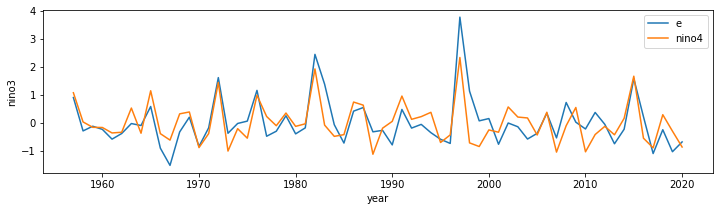

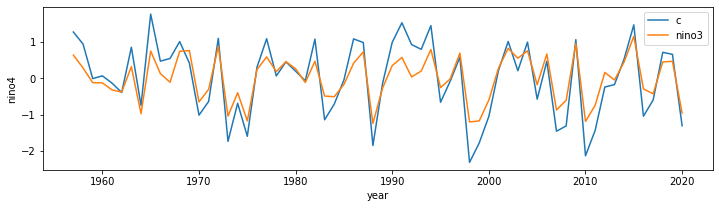

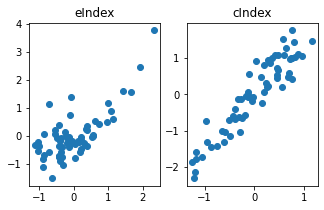

In [26]:
#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.eIndex.plot()
indexXr.nino3.plot()
plt.legend(['e','nino4'])


#plot vs time
fig = plt.figure(figsize=(12,3))
indexXr.cIndex.plot()
indexXr.nino4.plot()

#plt.xlim([1950,2050])
plt.legend(['c','nino3'])

#scatter plots
fig = plt.figure(figsize=(8,3))

plt.subplot(1,3,1)
plt.scatter(indexXr.nino3, indexXr.eIndex)
plt.title('eIndex')

plt.subplot(1,3,2)
plt.scatter(indexXr.nino4, indexXr.cIndex)
plt.title('cIndex')

plt.show()

# Marshall SAM

In [27]:
marshallPd=pandas.read_csv(
    'ref/marshallSam/newsam.1957.2007.txt',
    sep=' ', 
    skipinitialspace=True
)

In [28]:
marshallPd

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
1957,-0.87,-2.27,0.07,-1.97,-2.50,-0.87,1.00,-1.73,0.72,-3.12,-5.42,-2.63
1958,0.04,-2.84,-2.52,-0.30,-2.72,-0.97,-1.65,0.97,1.90,-0.16,0.30,0.82
1959,1.59,-0.19,-0.54,-1.25,-0.32,-1.12,0.18,-1.64,2.46,-0.46,3.28,-0.38
1960,0.90,0.85,3.40,-0.35,-0.60,-0.17,0.31,0.43,1.41,-1.17,1.18,1.36
1961,0.91,-4.00,-0.40,-0.14,1.12,-0.40,0.98,1.10,-1.21,1.64,1.52,2.32
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,-1.12,-1.09,-1.56,1.65,1.82,1.98,0.16,0.31,0.42,-0.64,3.18,1.44
2018,2.72,1.02,-0.03,-1.66,0.01,-1.57,0.55,-0.78,1.83,2.76,2.84,1.44
2019,2.79,-1.87,1.47,0.86,-0.11,2.21,-2.20,-2.04,0.81,-1.97,-4.42,-1.78
2020,0.57,-0.36,2.05,-1.72,1.03,1.18,-0.97,-2.20,-0.25,1.79,1.14,2.28


In [29]:
marshallXr=marshallPd.to_xarray().to_array('month').rename({'index':'year'})

In [30]:
indexXr['samSummer']=xarray.DataArray(
    (
        marshallXr.sel(
            year=range(1957,2021),
            month=['OCT','NOV','DEC']
        ).sum('month').values  #This is the sep to dec sum for each year
        + marshallXr.sel(
            year=range(1958,2022),
            month=['JAN','FEB','MAR']
        ).sum('month').values   #This is the jan feb sum for the next year
    )/6, 
    {'year':marshallXr.year.values[0:-1]}, 
    dims='year'
)

In [31]:
indexXr['samWinter']=(
     marshallXr.sel(
        year=range(1957,2021),
        month=['APR','MAY','JUN','JUL','AUG','SEP']
    ).sum('month')
)/6

In [32]:
indexXr

<xarray.Dataset>
Dimensions:                 (year: 64)
Coordinates:
  * year                    (year) int64 1957 1958 1959 1960 ... 2018 2019 2020
Data variables: (12/16)
    nino34NoDetrend         (year) float64 1.183 0.1822 ... 0.4823 -0.8275
    nino4NoDetrend          (year) float64 0.4334 0.1294 ... 0.9657 -0.502
    westIONoDetrend         (year) float64 -0.4674 -0.3855 ... 0.8908 0.4204
    eastIO                  (year) float64 0.005738 0.5618 ... -0.8846 0.121
    backgroundSstNoDetrend  (year) float64 -0.01563 -0.1544 ... 0.5034 0.1919
    westIO                  (year) float64 -0.0632 -0.0215 ... 0.2948 -0.2123
    ...                      ...
    dmi                     (year) float64 -0.06894 -0.5833 ... 1.179 -0.3332
    dmiNoDetrend            (year) float64 -0.2578 -0.656 ... 1.441 0.01628
    eIndex                  (year) float64 0.8971 -0.2954 ... -1.039 -0.6884
    cIndex                  (year) float64 1.267 0.9372 ... 0.6534 -1.307
    samSummer               (year) float64 -2.748 0.3033 1.265 ... -0.985 1.4
    samWinter               (year) float64 -0.8917 -0.4617 ... -0.07833 -0.4883

In [33]:
#save them for use elsewhere

indexXr.to_netcdf('results/obsIndeces.nc')

PermissionError: [Errno 13] Permission denied: b'/home/603/as2285/compound/results/obsIndeces.nc'

# Now, set some criteria to determine events

Per normal, 1 sigma for enso/iod. 0.5 sigma for SAM.

However, we don't have a good baseline period. Lets choose 1900-1930 (somewhat arbitrary?)

In [ ]:
indexXr=xarray.open_dataset('results/obsIndeces.nc')

In [ ]:
stdXr=indexXr.std()

In [ ]:
criteriaXr=stdXr[['dmi','nino34', 'eastIO', 'eIndex', 'cIndex']]
criteriaXr['samWinter']=stdXr.samWinter/2
criteriaXr['samSummer']=stdXr.samSummer/2

In [ ]:
criteriaXr

In [ ]:
firePosXr, fireNegXr = compound.applyCriteria(indexXr, criteriaXr)

In [ ]:
firePosXr

In [ ]:
eventsXr=xarray.concat(
    [
        firePosXr,
        fireNegXr
    ],
    'fire')

eventsXr['fire']=['pos','neg']

In [ ]:
eventsXr['ecCombined']=eventsXr[['eIndex','cIndex']].to_array().any('variable')*1.0

In [ ]:
eventsXr

In [ ]:
eventsXr.to_netcdf('results/obsEvents.nc')

In [ ]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='pos')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

Cai et al. 2015, (starting 1979, using ORA-s4 SST, DJF averages) identifies El Nino as:
- CP: 1990, 2002, 2004, 2009
- EP: 1982, 1997
They seem to match ok

Abram et al 2020 (observational):
- IOD: 1982, 1991, 1994, 1997, 2007, 2008, 2012, 2015, 2019 (bad)


In [ ]:
#event years

for iEvent in eventsXr.data_vars:

    years=eventsXr.where(
        eventsXr[iEvent].sel(fire='neg')==True, 
        drop=True
    ).year.values
    
    print(str(iEvent) + ' : ' + str(years))

# Check events against the initial SSTs:

In [ ]:
ensoSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='nino34'))
iodSeasonXr=tp.averageForTimePeriod(sstXr.ssta.to_dataset(name='dmi'))

In [ ]:
%run helpers/impactPlots.ipynb

In [ ]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

In [ ]:
indexPlotter(
    ensoSeasonXr.nino34.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['eIndex','cIndex','nino34'],
    showOcean=True, 
    stipling=False
)

In [ ]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='pos'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)

In [ ]:
indexPlotter(
    iodSeasonXr.dmi.rename('ts'), 
    eventsXr.sel(fire='neg'),
    ['dmi'],
    showOcean=True, 
    stipling=False
)